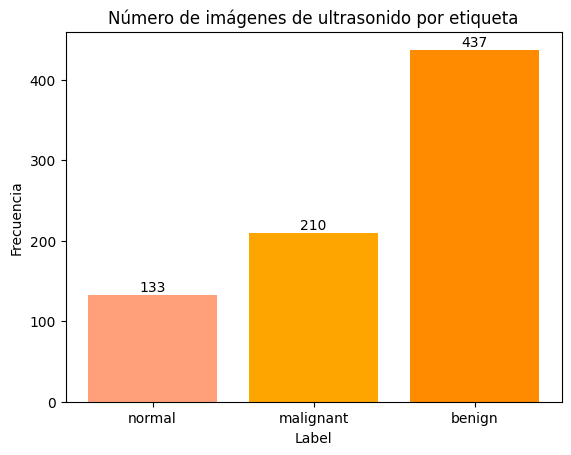

In [57]:
## Avance 1 de proyecto
## Título: Comparación de algoritmos de segmentación para la detección de cáncer de mama a partir de imágenes de ultrasonido
## Autores: Alessandra Mercedes Aldave Javier, Valeria Oriana Zavaleta Jave


# Importación de librerías
import os
import glob
import matplotlib.pyplot as plt
from collections import Counter
import cv2
import random
import tensorflow as tf


# Paths de la ubicación de cada carpeta de datos
normal_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\normal"
malignant_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\malignant"
benign_path = r"C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\benign"


# Función para cargar dataset de imágenes
    # Se usara un diccionario para guardar el path correspondiente a una imagen x (como key), y como value se tendra una lista cuyos elementos son: la etiqueta de esa imagen x, y el path de la mascara de la imagen x (lo mismo para todas las imagenes)
def CargarImagenesYMascaras(path_de_file):
    dataset = {} # Creación del diccionario
    for path_de_imagen in glob.glob(os.path.join(path_de_file, '*.png')):
        filename = os.path.basename(path_de_imagen)
        label = filename.split('(')[0].strip()
        if "_mask" not in filename:
            dataset[path_de_imagen] = label
    return dataset

# Cargar paths de imágenes de ultrasonido con su respectivo label y path de imagenes de mascaras 
dataset = {}
dataset.update(CargarImagenesYMascaras(normal_path))
dataset.update(CargarImagenesYMascaras(malignant_path))
dataset.update(CargarImagenesYMascaras(benign_path))

# Determinación de la cantidad de imagenes de ultrasonido de cada tipo (o de cada label)
diccionario_conteo_labels = Counter(label for label in dataset.values())

# Gráfico de barras 
barras = plt.bar(diccionario_conteo_labels.keys(), diccionario_conteo_labels.values(), color= ['#FFA07A', '#FFA500', '#FF8C00'])
plt.xlabel('Label')
plt.ylabel('Frecuencia')
plt.title('Número de imágenes de ultrasonido por etiqueta')

for barra_label in barras:
    altura = barra_label.get_height()
    plt.text(barra_label.get_x() + barra_label.get_width() / 2, altura, altura, ha='center', va='bottom')

plt.show()


In [58]:
#Division aleatoria del dataset en 75% y 25%
dataset_items = list(dataset.items())
random.shuffle(dataset_items)
train_size = int(len(dataset_items) * 0.75)
train_set = dict(dataset_items[:train_size])
test_set = dict(dataset_items[train_size:])

Imágenes de ultrasonido normales:
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\normal\normal (15).png
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\normal\normal (45).png
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\normal\normal (8).png


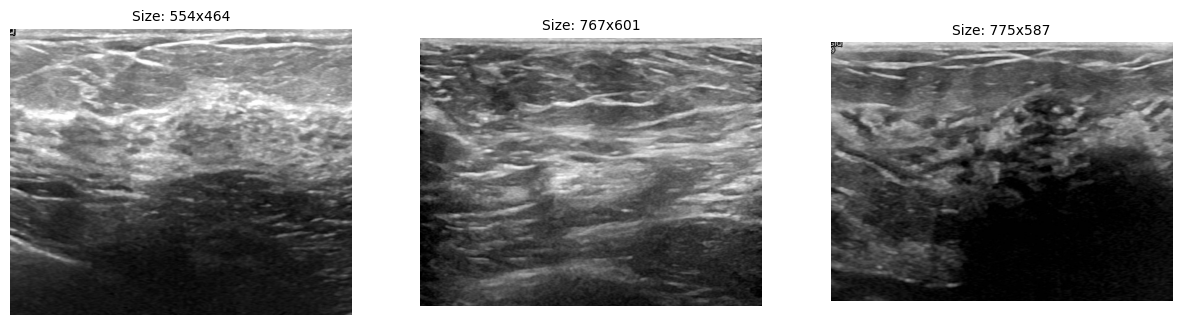


Imágenes de ultrasonido benignas:
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\benign\benign (296).png
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\benign\benign (11).png
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\benign\benign (23).png


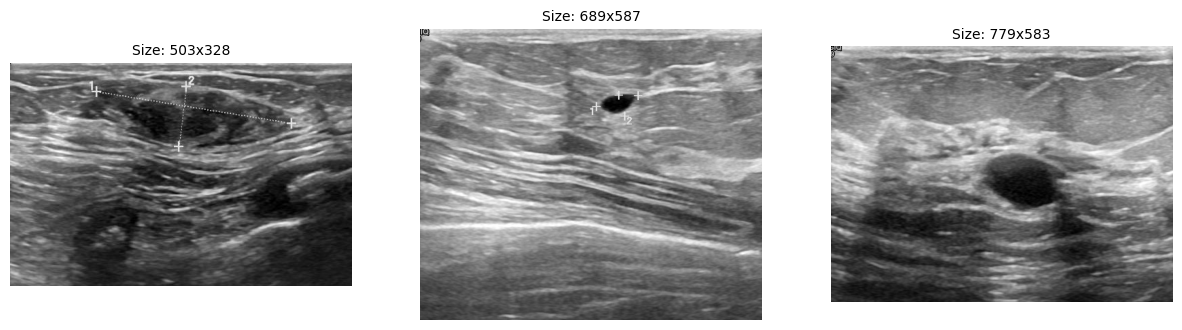


Imágenes de ultrasonido malignas:
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\malignant\malignant (33).png
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\malignant\malignant (131).png
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\malignant\malignant (170).png


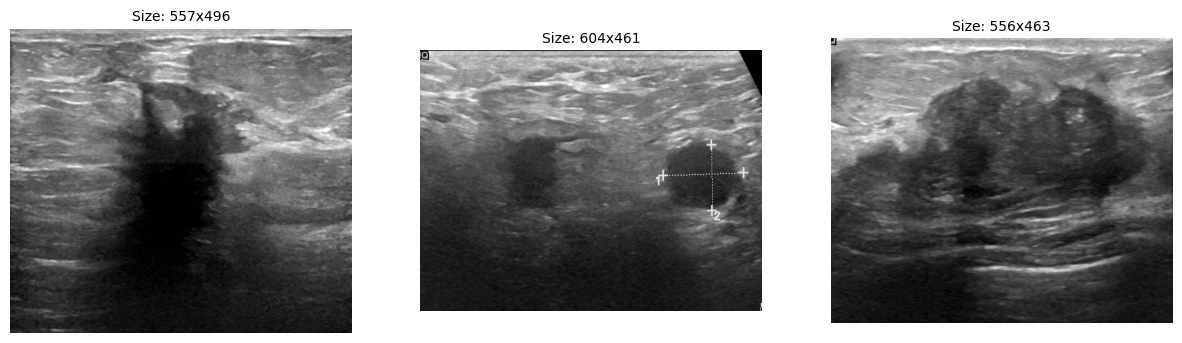

In [59]:
# Muestra de las primeras tres images de cada etiqueta del dataset
def Mostrar3Imagenes(image_paths):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        if i < len(axes):  
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i].imshow(image_rgb)
            axes[i].axis('off')

            # Características de la imagen
            propiedades_imagenes = f"Size: {image.shape[1]}x{image.shape[0]}"
            axes[i].set_title(propiedades_imagenes, fontsize=10)

            # Path de las imagenes
            print(image_path)
    plt.show()

# Seleccion de 3 imagenes de cada categoria sin tomar en cuenta las mascaras
normal_images = random.sample([path for path, label in dataset.items() if label == 'normal'], 3)
benign_images = random.sample([path for path, label in dataset.items() if label == 'benign'], 3)
malignant_images = random.sample([path for path, label in dataset.items() if label == 'malignant'], 3)


print("Imágenes de ultrasonido normales:")
Mostrar3Imagenes(normal_images)
print("\nImágenes de ultrasonido benignas:")
Mostrar3Imagenes(benign_images)
print("\nImágenes de ultrasonido malignas:")
Mostrar3Imagenes(malignant_images)


Primeras tres imágenes aumentadas del conjunto de entrenamiento:
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\normal\normal (65)_augmented.png
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\malignant\malignant (142)_augmented.png
C:\Users\Alessandra\Downloads\ProyectoReconocimientoPatrones\Dataset_BUSI_with_GT\normal\normal (106)_augmented.png


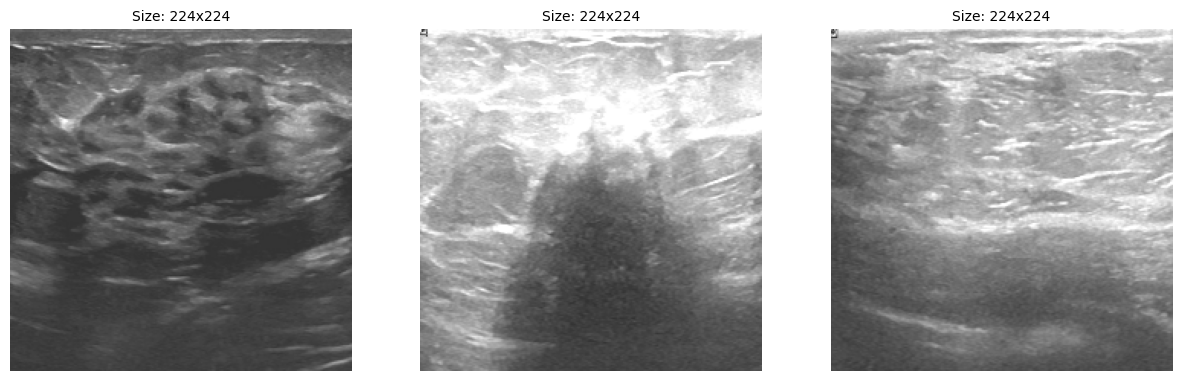

Train Set:
Número de Imágenes: 1170
Counter({'benign': 648, 'malignant': 308, 'normal': 214})

Test Set:
Número de Imágenes: 195
Counter({'benign': 113, 'malignant': 56, 'normal': 26})


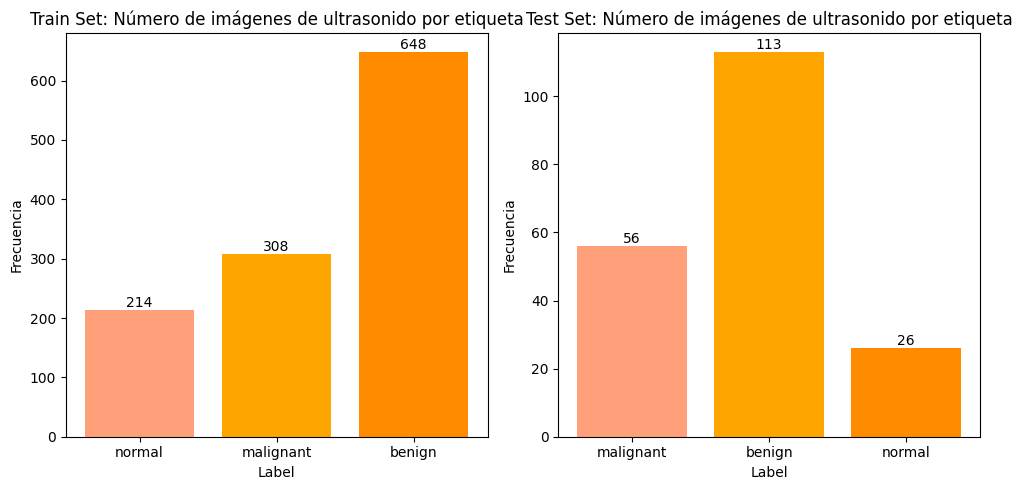

In [60]:
# Data augmentation
def DataAugmentation(dataset):
    augmented_dataset = {}
    
    for path, label in dataset.items():
        # Lectura de las imágenes
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels=3)  # Assuming images are RGB

        # Aplicamos transformaciones secuenciales
        image = tf.keras.layers.Resizing(224, 224)(image)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.adjust_brightness(image, delta=0.2)
        image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=(1, 2))
        
        # Guardamos las imagenes sintetizadas en las respectivas carpetas del dataset
        augmented_path = path.replace('.png', '_augmented.png')
        cv2.imwrite(augmented_path, image.numpy())
        
        # Actualizamos el dataset indicandole la etiqueta correspondiente de la imagen creada
        augmented_dataset[augmented_path] = label

    return augmented_dataset

# Aplicación de data augmentation al training set
train_set_augmented = DataAugmentation(train_set)

# Update training set con los augmented images
train_set.update(train_set_augmented)

print("\nPrimeras tres imágenes aumentadas del conjunto de entrenamiento:")
Mostrar3Imagenes(list(train_set_augmented.keys())[:3])

# Determinación de la cantidad de imagenes de ultrasonido de cada tipo (o de cada label)
diccionario_conteo_labels_train = Counter(label for label in train_set.values())
diccionario_conteo_labels_test = Counter(label for label in test_set.values())

# Mostrando informacion del train y test sets
#print("Train Set:")
#print("Número de Imágenes:", len(train_set))
#print(diccionario_conteo_labels_train)

#print("\nTest Set:")
#print("Número de Imágenes:", len(test_set))
#print(diccionario_conteo_labels_test)

# Gráfico de barras para el train set
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
barras_train = plt.bar(diccionario_conteo_labels_train.keys(), diccionario_conteo_labels_train.values(), color= ['#FFA07A', '#FFA500', '#FF8C00'])
plt.xlabel('Label')
plt.ylabel('Frecuencia')
plt.title('Train Set: Número de imágenes de ultrasonido por etiqueta')
for barra_label in barras_train:
    altura = barra_label.get_height()
    plt.text(barra_label.get_x() + barra_label.get_width() / 2, altura, altura, ha='center', va='bottom')

# Grafico de barras para el test set
plt.subplot(1, 2, 2)
barras_test = plt.bar(diccionario_conteo_labels_test.keys(), diccionario_conteo_labels_test.values(), color= ['#FFA07A', '#FFA500', '#FF8C00'])
plt.xlabel('Label')
plt.ylabel('Frecuencia')
plt.title('Test Set: Número de imágenes de ultrasonido por etiqueta')
for barra_label in barras_test:
    altura = barra_label.get_height()
    plt.text(barra_label.get_x() + barra_label.get_width() / 2, altura, altura, ha='center', va='bottom')

plt.tight_layout()
plt.show()